In [1]:
from google.cloud import storage
import pandas as pd
import pyarrow.parquet as pq
import io
import ast
import numpy as np
import koreanize_matplotlib
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap

# 한글 깨짐 방지 (옵션)
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'  # Windows # 나눔고딕 가능
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 부호 깨짐 방지

In [2]:
client = storage.Client()

bucket_name = 'sprint_project4'
file_path = "sprint_project4/votes"

bucket = client.bucket(bucket_name)
blob = bucket.blob(file_path)

## 1. 사용 데이터

### 학급 테이블

In [3]:
blob = bucket.blob('votes/accounts_group.parquet')
parquet_bytes = blob.download_as_bytes()
group = pd.read_parquet(io.BytesIO(parquet_bytes))
group.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


In [4]:
# grade와 class_num 이상치 제거
# group_df = group.copy()

group_df = group[(~group['grade'].isin([4,20])) & (~group['class_num'].isin([0,41]))]
group_df

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1
...,...,...,...,...
84510,84542,3,2,5107
84511,84543,2,7,3487
84512,84544,3,1,5043
84513,84545,2,7,416


In [5]:
id_school_df = group[['id', 'school_id']].copy()

### 학교 테이블

In [6]:
blob = bucket.blob('votes/accounts_school.parquet')
parquet_bytes = blob.download_as_bytes()
school = pd.read_parquet(io.BytesIO(parquet_bytes))
school.head()

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M


### 12. accounts_user(유저)
- is_superuser : superuser 여부
- is_staff : staff 여부
- firebase_id : 과거 firebase 세션 관리 할 때 사용하는 식별자(이 컬럼은 제거 예정)
- friend_id_list : 친구 id 데이터
- block_user_id_list : 차단한 유저 id 데이터
- hide_user_id_list : 숨김 처리한 유저 id 데이터
- ban_status : 차단 혹은 탈퇴한 유저인지 타입
- report_count : 신고 당한 횟수
- alarm_count : 알람 갯수
- pending_chat: 안읽은 채팅 개수
- pending_votes : 확인 안한 투표 개수

In [7]:
blob = bucket.blob('votes/accounts_user.parquet')
parquet_bytes = blob.download_as_bytes()
user = pd.read_parquet(io.BytesIO(parquet_bytes))
user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [8]:
# is_superuser, is_staff 값이 1인 row 제거 및 컬럼 제거

# 1. superuser와 is_staff =1인 행 제거
user =user[(user['is_superuser'] != 1) & (user['is_staff'] != 1)]

# 2. superuser와 is_staff 컬럼 제거
user = user.drop(columns=['is_superuser', 'is_staff'])
user.head()

,id,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
1,831962,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0
5,832614,M,1048,"[838541, 833041, 832151, 837806, 1437874, 1142...",1,2023-03-29 12:56:35.064406,[],[],N,0,28,0,14,12.0


In [9]:
user_df = user.copy()

# 사용 데이터 기간 5,6,7월
user_df = user[
    (user['created_at'].dt.year == 2023) &
    (user['created_at'].dt.month.isin([5, 6, 7]))
]
user_df.head()

,id,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
13302,855179,M,1358,"[849767, 850569, 857770, 856249, 850108, 869470]",1,2023-05-18 16:36:23.667542,[],[],N,0,1,0,23,5532.0
19094,862517,F,1391,"[880775, 838285, 868495, 875156, 838421, 83842...",1,2023-05-01 00:00:12.942200,[],[],N,0,1,0,19,6337.0
19095,862518,F,1063,"[857473, 846981, 860934, 858247, 859913, 86901...",1,2023-05-01 00:00:22.647793,[],[],N,0,0,0,61,7020.0
19096,862519,F,2137,"[1215494, 1150344, 1520776, 1160844, 1090445, ...",0,2023-05-01 00:00:32.161347,[],[],N,0,2,0,180,7392.0
19097,862520,M,2838,"[874368, 856706, 1407234, 982788, 1145859, 100...",1,2023-05-01 00:00:48.974195,[],[],N,0,1,0,190,3526.0


### 13. accounts_userquestionrecord(투표기록)
- status : 상태(C : closed(닫힘), I : initial(초성 열림), B: blocked(차단))
- chosen_user_id : 선택 받은 유저 id
- opened_times : 열어본 횟수
- question_id : 질문 id
- question_piece_id : 투표 id
- answer_status : 답장 상태(N : 미답변, P : 비공개, A : 공개)
- answer_updated_at : 답장 시간
- report_count : 신고 횟수
- has_read : 읽었는지 여부

In [10]:
blob = bucket.blob('votes/accounts_userquestionrecord.parquet')
parquet_bytes = blob.download_as_bytes()
userquestionrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
userquestionrecord.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [11]:
# 사용 데이터 기간 5,6,7월
userquestionrecord_df = userquestionrecord[
    (userquestionrecord['created_at'].dt.year == 2023) &
    (userquestionrecord['created_at'].dt.month.isin([4, 5, 6, 7]))
]
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


## 2. 회원가입 유저들 중 투표한 유저 구하기(account_user, userquestionrecord)
- 10개 학교의 학생 데이터로만 분석
    - 투표율 재정의
        - 분모 : 10개 학교 학생들의 일별 누적 가입자 수
            - 탈퇴한 유저 제외 불가
        - 분자 : 10개 학교 학생들 중 일별 투표 참여 수

In [12]:
# 유저 투표 기록 => 4835명(5월~7월), 5074명
userquestionrecord_df.head()
print("투표 기록 존재하는 유니크 유저 수")
print(userquestionrecord_df['user_id'].nunique())

투표 기록 존재하는 유니크 유저 수
4845


In [13]:
# account_user에서 필요한 컬럼만 선택하고, id를 user_id로 변경
user_filtered = user[[
    'id', 'gender', 'is_push_on', 'ban_status', 
    'alarm_count', 'group_id', 'created_at'
]].rename(columns={'id': 'user_id', 'created_at':'user_created_at'})

user_filtered

# 2023년 7월 31일까지 필터링
user_filtered = user_filtered[user_filtered['user_created_at'] <= '2023-07-31']
user_filtered.head()

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at
1,831962,F,1,N,40878,12.0,2023-03-29 05:18:56.162368
2,832151,M,0,N,37,1.0,2023-03-29 12:56:34.989468
3,832340,F,1,N,19,1.0,2023-03-29 12:56:35.020790
4,832520,M,0,N,29,12.0,2023-03-29 12:56:35.049311
5,832614,M,1,N,28,12.0,2023-03-29 12:56:35.064406


In [14]:
# account_user와 userquestionrecord에 공통으로 존재하는 유저들 추출(id = user_id) -> 공통 존재 유저들의 학교id 알아내기 위해

# userquestionrecord에서 user_id 목록 추출 
voted_user_ids = userquestionrecord_df['user_id'].unique()

# user에서 해당 user_id만 추출
voted_user = user_filtered[user_filtered['user_id'].isin(voted_user_ids)]

# 결과 확인
print(voted_user.head())
print(f"투표 기록이 있는 유저 수: {voted_user['user_id'].nunique()}")

      user_id gender  is_push_on ban_status  alarm_count  group_id  \
396    838023      F           1          N            1     233.0   
633    838466      F           1          N            1     321.0   
756    838642      F           1          N            0     356.0   
1252   839357      M           1          N            1     519.0   
1889   840293      F           1          N            2     838.0   

                user_created_at  
396  2023-04-19 09:06:00.719792  
633  2023-04-19 15:10:56.560337  
756  2023-04-20 00:11:00.962160  
1252 2023-04-20 14:26:20.479856  
1889 2023-04-21 11:45:56.750174  
투표 기록이 있는 유저 수: 4845


In [15]:
# 학교 정보 group_id 기준 merge

# group 데이터에서 id → group_id로 이름 변경 (병합을 위해)
group_renamed = id_school_df.rename(columns={'id': 'group_id'})

# voted_user와 group_renamed 병합
voted_user = pd.merge(voted_user, group_renamed, on='group_id', how='left')
voted_user.head()

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at,school_id
0,838023,F,1,N,1,233.0,2023-04-19 09:06:00.719792,271
1,838466,F,1,N,1,321.0,2023-04-19 15:10:56.560337,369
2,838642,F,1,N,0,356.0,2023-04-20 00:11:00.962160,271
3,839357,M,1,N,1,519.0,2023-04-20 14:26:20.479856,271
4,840293,F,1,N,2,838.0,2023-04-21 11:45:56.750174,369


In [16]:
# school_id 추출
school_ids = voted_user['school_id'].unique()

# ② school_id를 DataFrame으로 변환
voted_school_id = pd.DataFrame({'school_id': school_ids})
voted_school_id

,school_id
0,271
1,369
2,5491
3,352
4,4516
5,4426
6,1478
7,5520
8,5372
9,1719


In [17]:
# 7월까지 필터링한 user 데이터에 학교 정보 추가

# group 테이블에서 id → group_id로 이름 변경
group_renamed = id_school_df.rename(columns={'id': 'group_id'})

# user_filtered와 group_renamed 병합
user_school_info = pd.merge(user_filtered, group_renamed, on='group_id', how='left')
user_school_info.head()

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at,school_id
0,831962,F,1,N,40878,12.0,2023-03-29 05:18:56.162368,1.0
1,832151,M,0,N,37,1.0,2023-03-29 12:56:34.989468,1.0
2,832340,F,1,N,19,1.0,2023-03-29 12:56:35.020790,1.0
3,832520,M,0,N,29,12.0,2023-03-29 12:56:35.049311,1.0
4,832614,M,1,N,28,12.0,2023-03-29 12:56:35.064406,1.0


In [18]:
#  투표한 학생들이 존재하는 학교에 해당하는 유저들 추출
user_school_info = user_school_info[user_school_info['school_id'].notna()].copy()

# school_id 컬럼 int로 
voted_school_id['school_id'] = voted_school_id['school_id'].astype(int)
user_school_info['school_id'] = user_school_info['school_id'].astype(int)

# 필터링: voted_school_id에 있는 school_id만 남기기
user_school_info = user_school_info[user_school_info['school_id'].isin(voted_school_id['school_id'])]

# 유저 투표 기록 => 4835명(5월~7월), 5074명
print(f"투표기록이 있는 학생들이 속한 학교 유니크 회원가입 유저 수: {user_school_info.shape[0]}")
print(f"투표 기록 존재하는 유니크 유저 수 : {userquestionrecord_df['user_id'].nunique()}")

투표기록이 있는 학생들이 속한 학교 유니크 회원가입 유저 수: 5074
투표 기록 존재하는 유니크 유저 수 : 4845


## 3. kpi 구하기

### 3-1. 일별 누적 회원 가입수 

In [19]:
# 1. 날짜만 추출
user_school_info['user_date'] = user_school_info['user_created_at'].dt.date

# 2. 전체 날짜 범위: 실제 시작 ~ 7월 31일
full_user_date_range = pd.DataFrame({
    'user_date': pd.date_range(
        start=user_school_info['user_date'].min(),
        end=pd.to_datetime('2023-07-31')
    ).date
})

# 3. 일별 회원가입자 수
daily_user = (
    user_school_info.groupby('user_date')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'daily_user_count'})
)

# 4. 병합 후 가입 없는 날은 0으로
daily_user_complete = pd.merge(full_user_date_range, daily_user, on='user_date', how='left').fillna(0)
daily_user_complete['daily_user_count'] = daily_user_complete['daily_user_count'].astype(int)

# 5. 누적 가입자 수
daily_user_complete['cumulative_user_count'] = daily_user_complete['daily_user_count'].cumsum()

# 6. 5월 1일부터만 필터링
daily_user_filtered = daily_user_complete[
    daily_user_complete['user_date'] >= pd.to_datetime('2023-04-28').date()
]

# 7. DataFrame 분리
daily_user = daily_user_filtered[['user_date', 'daily_user_count']].copy()
cumulative_user = daily_user_filtered[['user_date', 'cumulative_user_count']].copy()

# 결과 확인
print("일별 회원 가입자 수")
display(daily_user)
print("일별 누적 회원 가입자 수")
display(cumulative_user)

일별 회원 가입자 수


,user_date,daily_user_count
9,2023-04-28,142
10,2023-04-29,118
11,2023-04-30,121
12,2023-05-01,43
13,2023-05-02,99
...,...,...
99,2023-07-27,0
100,2023-07-28,0
101,2023-07-29,0
102,2023-07-30,0


일별 누적 회원 가입자 수


,user_date,cumulative_user_count
9,2023-04-28,164
10,2023-04-29,282
11,2023-04-30,403
12,2023-05-01,446
13,2023-05-02,545
...,...,...
99,2023-07-27,5074
100,2023-07-28,5074
101,2023-07-29,5074
102,2023-07-30,5074


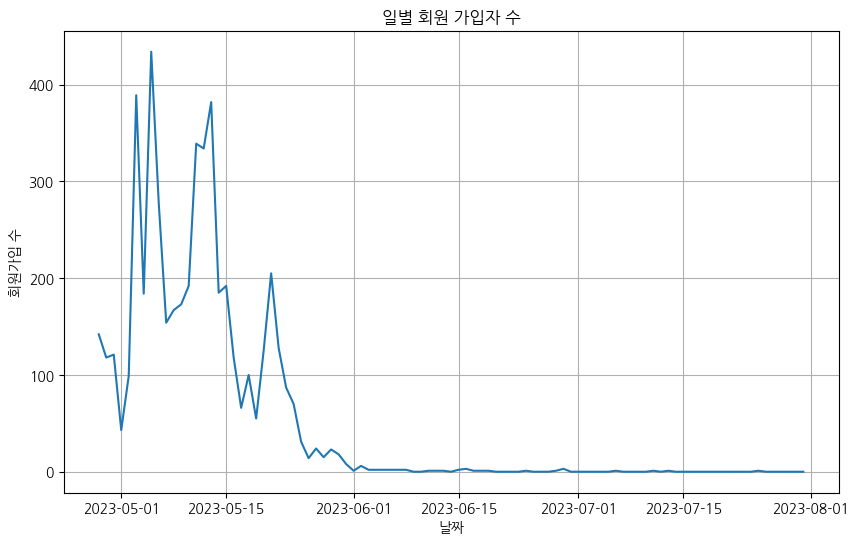

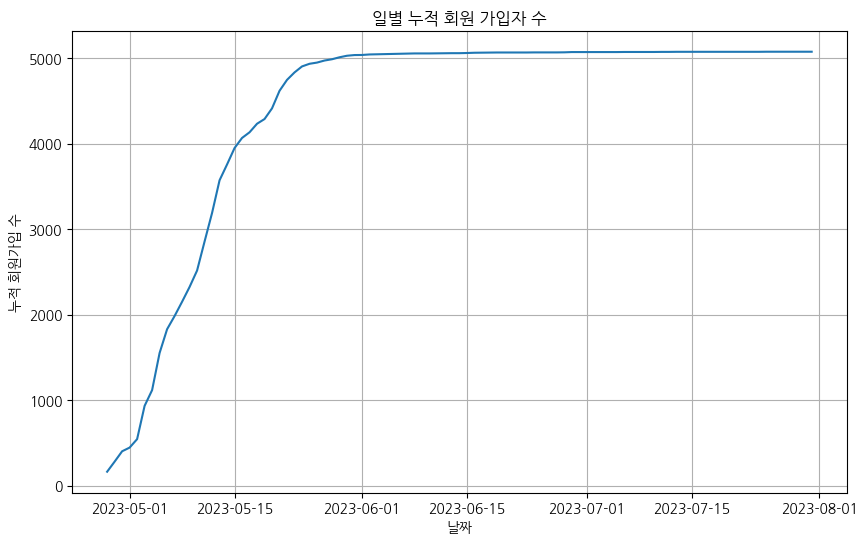

In [20]:
# 일별 회원가입자 수
plt.figure(figsize = (10,6))
sns.lineplot(data = daily_user, x = 'user_date', y = 'daily_user_count')
plt.title("일별 회원 가입자 수")
plt.xlabel('날짜')
plt.ylabel("회원가입 수")
plt.grid()
plt.show()


# 일별 누적 회원가입자 수
plt.figure(figsize = (10,6))
sns.lineplot(data = cumulative_user, x = 'user_date', y = 'cumulative_user_count')
plt.title("일별 누적 회원 가입자 수")
plt.xlabel('날짜')
plt.ylabel("누적 회원가입 수")
plt.grid()
plt.show()

### 3-2. 일별 투표 유저 수

In [21]:
questionrecord_df = userquestionrecord_df.copy()

# 1. 날짜만 추출
questionrecord_df['vote_date'] = questionrecord_df['created_at'].dt.date

# 2. 일별 고유 유저 수 집계
daily_vote = (
    questionrecord_df.groupby('vote_date')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'daily_vote_count'})
)

# 3. 5월 1일 이후만 필터링
#daily_vote = daily_vote[daily_vote['vote_date'] >= pd.to_datetime('2023-05-01').date()]
daily_vote

,vote_date,daily_vote_count
0,2023-04-28,125
1,2023-04-29,221
2,2023-04-30,325
3,2023-05-01,325
4,2023-05-02,413
...,...,...
90,2023-07-27,14
91,2023-07-28,14
92,2023-07-29,17
93,2023-07-30,11


### 3-3. 누적 회원가입 유저 데이터 + 일별 투표 유저 데이터 merge

In [22]:
# 날짜 컬럼 이름을 통일
daily_vote_renamed = daily_vote.rename(columns={'vote_date': 'date'})
cumulative_user_renamed = cumulative_user.rename(columns={'user_date': 'date'})

# 날짜 기준 병합
ratio_df = pd.merge(daily_vote_renamed, cumulative_user_renamed, on='date', how='outer')

# 날짜 정렬
ratio_df = ratio_df.sort_values(by='date').reset_index(drop=True)
ratio_df

,date,daily_vote_count,cumulative_user_count
0,2023-04-28,125,164
1,2023-04-29,221,282
2,2023-04-30,325,403
3,2023-05-01,325,446
4,2023-05-02,413,545
...,...,...,...
90,2023-07-27,14,5074
91,2023-07-28,14,5074
92,2023-07-29,17,5074
93,2023-07-30,11,5074


In [23]:
# 날짜별 투표율 계산
ratio_df['vote_rate'] = (ratio_df['daily_vote_count'] / ratio_df['cumulative_user_count']) * 100

# 소수점 2자리까지 반올림
ratio_df['vote_rate'] = ratio_df['vote_rate'].round(2)
ratio_df[['date', 'daily_vote_count', 'cumulative_user_count', 'vote_rate']]

,date,daily_vote_count,cumulative_user_count,vote_rate
0,2023-04-28,125,164,76.22
1,2023-04-29,221,282,78.37
2,2023-04-30,325,403,80.65
3,2023-05-01,325,446,72.87
4,2023-05-02,413,545,75.78
...,...,...,...,...
90,2023-07-27,14,5074,0.28
91,2023-07-28,14,5074,0.28
92,2023-07-29,17,5074,0.34
93,2023-07-30,11,5074,0.22


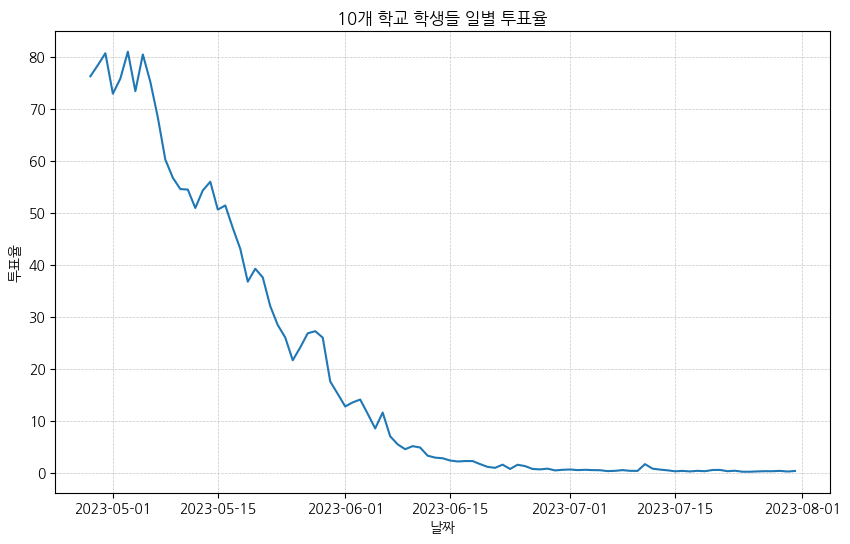

In [24]:
# 10개 학교 유저들 일별 투표율
plt.figure(figsize = (10,6))
sns.lineplot(data = ratio_df, x = 'date', y = 'vote_rate')
plt.title("10개 학교 학생들 일별 투표율")
plt.xlabel('날짜')
plt.ylabel('투표율')
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

## 4. 투표한 유저들의 리텐션

In [25]:
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [26]:
# 투표 날짜 컬럼 년-월-일로 생성
userquestionrecord_df = userquestionrecord_df.copy()
userquestionrecord_df['vote_date'] = userquestionrecord_df['created_at'].dt.date

In [27]:
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,vote_date
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0,2023-04-28
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0,2023-04-28
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0,2023-04-28
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0,2023-04-28
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0,2023-04-28


In [28]:
# 각 유저별 일별 투표 수 및 순서(투표 순서)

#  유저별 + 날짜별 투표 수 집계
user_daily_vote_df = (
    userquestionrecord_df
    .groupby(['user_id', 'vote_date'])
    .size()
    .reset_index(name='daily_vote_count')
)
# 유저별 투표 날짜 순 정렬
user_daily_vote_df = user_daily_vote_df.sort_values(['user_id', 'vote_date'])

# 유저별로 투표 순서 번호 붙이기
user_daily_vote_df['vote_sequence'] = (
    user_daily_vote_df
    .groupby('user_id')
    .cumcount() + 1  # 0부터 시작하므로 +1
)

user_daily_vote_df

,user_id,vote_date,daily_vote_count,vote_sequence
0,838023,2023-04-29,1,1
1,838023,2023-04-30,6,2
2,838023,2023-05-02,1,3
3,838023,2023-05-03,10,4
4,838023,2023-05-04,4,5
...,...,...,...,...
50240,1579418,2023-07-25,9,1
50241,1579418,2023-07-26,17,2
50242,1579418,2023-07-28,7,3
50243,1579418,2023-07-29,7,4


### 리텐션

In [29]:
# 1. first_vote_date 기준으로 코호트 날짜 설정(유저별로 첫 투표 날짜(min))
vote_df = user_daily_vote_df.copy()
vote_df['first_vote_date'] = vote_df.groupby('user_id')['vote_date'].transform('min')

# 2. 가입일 기준 n일차 계산(첫날은 0일)
vote_df['day_n'] = (pd.to_datetime(vote_df['vote_date']) - pd.to_datetime(vote_df['first_vote_date'])).dt.days

# 3. 유저 수 집계 (코호트일, day_n 기준으로 몇 명이 활동했는가)
cohort_table = (
    vote_df
    .groupby(['first_vote_date', 'day_n'])['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'active_users'})
)

# 4. 코호트별 전체 유저 수 (Day 0 기준 유입자 수(해당 날짜가 첫 투표일임))
cohort_sizes = (
    cohort_table[cohort_table['day_n'] == 0]
    .rename(columns={'active_users': 'cohort_size'})[['first_vote_date', 'cohort_size']]
)

# 5. 병합하여 리텐션율 계산
cohort_table = cohort_table.merge(cohort_sizes, on='first_vote_date')
cohort_table['retention_rate'] = (cohort_table['active_users'] / cohort_table['cohort_size'] * 100).round(2)

# 6. 피벗 테이블 변환
cohort_retention = cohort_table.pivot(index='first_vote_date', columns='day_n', values='retention_rate').fillna(0)

In [30]:
cohort_retention

day_n,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-04-28,100.0,97.60,90.40,80.80,90.40,72.00,61.60,60.00,56.00,48.80,...,0.80,0.80,0.00,0.00,0.00,0.00,1.60,2.40,0.00,0.8
2023-04-29,100.0,98.99,85.86,89.90,83.84,67.68,63.64,64.65,51.52,45.45,...,0.00,0.00,3.03,0.00,0.00,0.00,0.00,1.01,1.01,0.0
2023-04-30,100.0,90.35,94.74,89.47,69.30,70.18,71.93,57.02,52.63,54.39,...,0.00,1.75,1.75,0.88,0.88,0.00,0.00,0.88,0.00,0.0
2023-05-01,100.0,86.11,83.33,63.89,72.22,55.56,63.89,58.33,44.44,30.56,...,0.00,0.00,0.00,0.00,0.00,2.78,2.78,0.00,0.00,0.0
2023-05-02,100.0,94.44,83.33,83.33,83.33,81.94,62.50,56.94,56.94,43.06,...,1.39,0.00,0.00,2.78,0.00,1.39,0.00,0.00,0.00,0.0
2023-05-03,100.0,90.60,92.17,87.73,82.25,68.41,60.84,50.13,42.30,33.16,...,0.00,0.00,0.00,0.00,0.78,0.00,0.00,0.00,0.00,0.0
2023-05-04,100.0,92.81,90.42,83.83,63.47,55.69,49.70,41.92,33.53,23.95,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2023-05-05,100.0,93.81,85.78,75.92,59.40,56.88,43.81,37.61,31.65,33.49,...,0.00,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2023-05-06,100.0,88.52,81.42,71.04,57.38,54.10,38.25,35.52,32.79,24.59,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


In [31]:
#  cohort_sizes의 first_vote_date 데이터 타입 변환
cohort_sizes['first_vote_date'] = pd.to_datetime(cohort_sizes['first_vote_date'])

# 1. cohort_retention의 index도 datetime 형식으로 재확인
cohort_retention.index = pd.to_datetime(cohort_retention.index)

# 2. cohort_sizes를 index로 변환
cohort_sizes_indexed = cohort_sizes.set_index('first_vote_date')

# 3. 병합 (index 기준)
retention = pd.concat([cohort_retention, cohort_sizes_indexed], axis=1)

# 4. 날짜 컬럼 순서 정리
day_cols = sorted([col for col in retention.columns if isinstance(col, int)])
final_cols = ['cohort_size'] + day_cols
retention = retention[final_cols]

,cohort_size,0,1,2,3,4,5,6,7,8,...,85,86,87,88,89,90,91,92,93,94
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-04-29,99,100.0,98.99,85.86,89.90,83.84,67.68,63.64,64.65,51.52,...,0.00,0.00,3.03,0.00,0.00,0.00,0.00,1.01,1.01,0.0
2023-04-30,114,100.0,90.35,94.74,89.47,69.30,70.18,71.93,57.02,52.63,...,0.00,1.75,1.75,0.88,0.88,0.00,0.00,0.88,0.00,0.0
2023-05-01,36,100.0,86.11,83.33,63.89,72.22,55.56,63.89,58.33,44.44,...,0.00,0.00,0.00,0.00,0.00,2.78,2.78,0.00,0.00,0.0
2023-05-02,72,100.0,94.44,83.33,83.33,83.33,81.94,62.50,56.94,56.94,...,1.39,0.00,0.00,2.78,0.00,1.39,0.00,0.00,0.00,0.0
2023-05-03,383,100.0,90.60,92.17,87.73,82.25,68.41,60.84,50.13,42.30,...,0.00,0.00,0.00,0.00,0.78,0.00,0.00,0.00,0.00,0.0
2023-05-04,167,100.0,92.81,90.42,83.83,63.47,55.69,49.70,41.92,33.53,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2023-05-05,436,100.0,93.81,85.78,75.92,59.40,56.88,43.81,37.61,31.65,...,0.00,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2023-05-06,183,100.0,88.52,81.42,71.04,57.38,54.10,38.25,35.52,32.79,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
2023-05-07,105,100.0,89.52,73.33,72.38,55.24,50.48,55.24,43.81,39.05,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


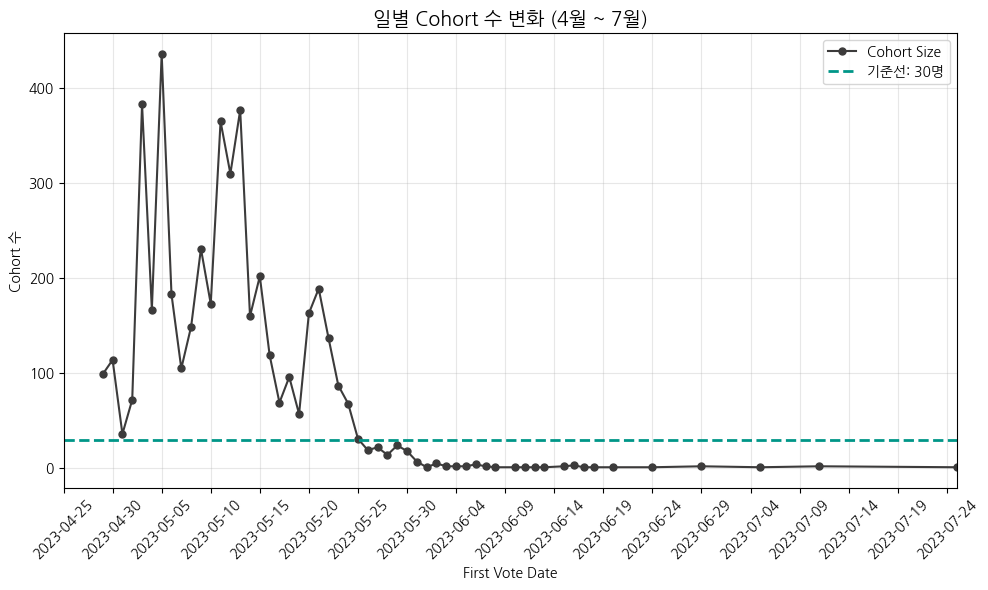

In [32]:
# 1. first_vote_date가 4월 28일 이상 5월 25일 이하인 것만 필터 
retention = retention['2023-04-28' < retention.index]
display(retention)

# 2. cohort_size가 30이상인 것을 사용한 이유를 보여주기 위한 시각화(ppt : 목표치 설정 eda 서비스 핵심 기간 확인)

cohort_sizes = retention['cohort_size']

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(cohort_sizes.index, cohort_sizes.values, marker='o', markersize = 5, linewidth=1.5, color='#3c3b3b', label='Cohort Size')

# 기준선 (30명)
plt.axhline(y=30, color='#009688', linestyle='--', linewidth=2, label='기준선: 30명')

# x축 시작 날짜 및 간격 설정
start_date = pd.to_datetime("2023-04-25")
end_date = cohort_sizes.index.max()

# 5일 간격 눈금 지정
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# x축 범위 지정
plt.xlim(start_date, end_date)

# 그래프 
plt.title('일별 Cohort 수 변화 (4월 ~ 7월)', fontsize=14)
plt.xlabel('First Vote Date')
plt.ylabel('Cohort 수')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [69]:
# 1. cohort_size가 30 이상인 cohort만 남기기
retention = retention[retention['cohort_size'] >= 30]

# 2. day_n이 30 이하인 컬럼만 남기기
filtered_day_cols = [col for col in day_cols if col <= 30]
final_cols = ['cohort_size'] + filtered_day_cols
retention = retention[final_cols]

# 분석에 이용 할 리텐션 기간 : 2023-04-29 ~ 2023-05-25
retention

,cohort_size,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-04-29,99,100.0,98.99,85.86,89.90,83.84,67.68,63.64,64.65,51.52,...,8.08,7.07,5.05,2.02,6.06,2.02,7.07,15.15,17.17,14.14
2023-04-30,114,100.0,90.35,94.74,89.47,69.30,70.18,71.93,57.02,52.63,...,17.54,13.16,14.04,14.91,14.04,15.79,13.16,22.81,22.81,14.04
2023-05-01,36,100.0,86.11,83.33,63.89,72.22,55.56,63.89,58.33,44.44,...,16.67,5.56,16.67,13.89,25.00,22.22,16.67,22.22,22.22,22.22
2023-05-02,72,100.0,94.44,83.33,83.33,83.33,81.94,62.50,56.94,56.94,...,20.83,12.50,12.50,12.50,23.61,20.83,25.00,16.67,9.72,5.56
2023-05-03,383,100.0,90.60,92.17,87.73,82.25,68.41,60.84,50.13,42.30,...,7.83,6.01,8.09,12.53,13.84,14.36,9.66,8.09,6.79,10.97
2023-05-04,167,100.0,92.81,90.42,83.83,63.47,55.69,49.70,41.92,33.53,...,5.39,6.59,10.18,6.59,7.78,4.19,3.59,3.59,8.38,2.99
2023-05-05,436,100.0,93.81,85.78,75.92,59.40,56.88,43.81,37.61,31.65,...,8.03,13.76,13.07,13.07,6.88,6.42,5.50,8.49,6.42,4.82
2023-05-06,183,100.0,88.52,81.42,71.04,57.38,54.10,38.25,35.52,32.79,...,13.66,6.56,8.74,6.01,8.20,2.19,6.01,4.37,3.28,4.37
2023-05-07,105,100.0,89.52,73.33,72.38,55.24,50.48,55.24,43.81,39.05,...,21.90,14.29,10.48,9.52,5.71,10.48,6.67,8.57,7.62,9.52


In [70]:
# 8일차 리텐션 기준으로 필터링
under_50 = retention[retention[8] < 50]
over_eq_50 = retention[retention[8] >= 50]

# 각 그룹의 cohort_size 합|
under_50_total = under_50['cohort_size'].sum()
over_eq_50_total = over_eq_50['cohort_size'].sum()

print(f"7일차 리텐션이 50% 미만인 그룹의 전체 cohort_size 합: {under_50_total}")
print(f"7일차 리텐션이 50% 이상인 그룹의 전체 cohort_size 합: {over_eq_50_total}")

7일차 리텐션이 50% 미만인 그룹의 전체 cohort_size 합: 2862
7일차 리텐션이 50% 이상인 그룹의 전체 cohort_size 합: 1716


In [71]:
# 컬러맵
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ['#f7f7f7', '#009688',  '#ffc107'])

In [72]:
# cohort_size 제외
heatmap_data = retention.drop(columns='cohort_size')

# 인덱스를 문자열로 변환
heatmap_data.index = heatmap_data.index.strftime('%Y-%m-%d')

# 히트맵
plt.figure(figsize=(15, 8))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".1f", cmap=custom_cmap, linewidths=0.5, linecolor='gray',
    cbar_kws={'label': 'Retention Rate (%)'}
)

plt.title('Retention Heatmap (Day 0~30)', fontsize=16)
plt.xlabel('Days Since First Vote')
plt.ylabel('First Vote Date (Cohort)')
plt.tight_layout()
plt.show()

AttributeError: 'Index' object has no attribute 'strftime'

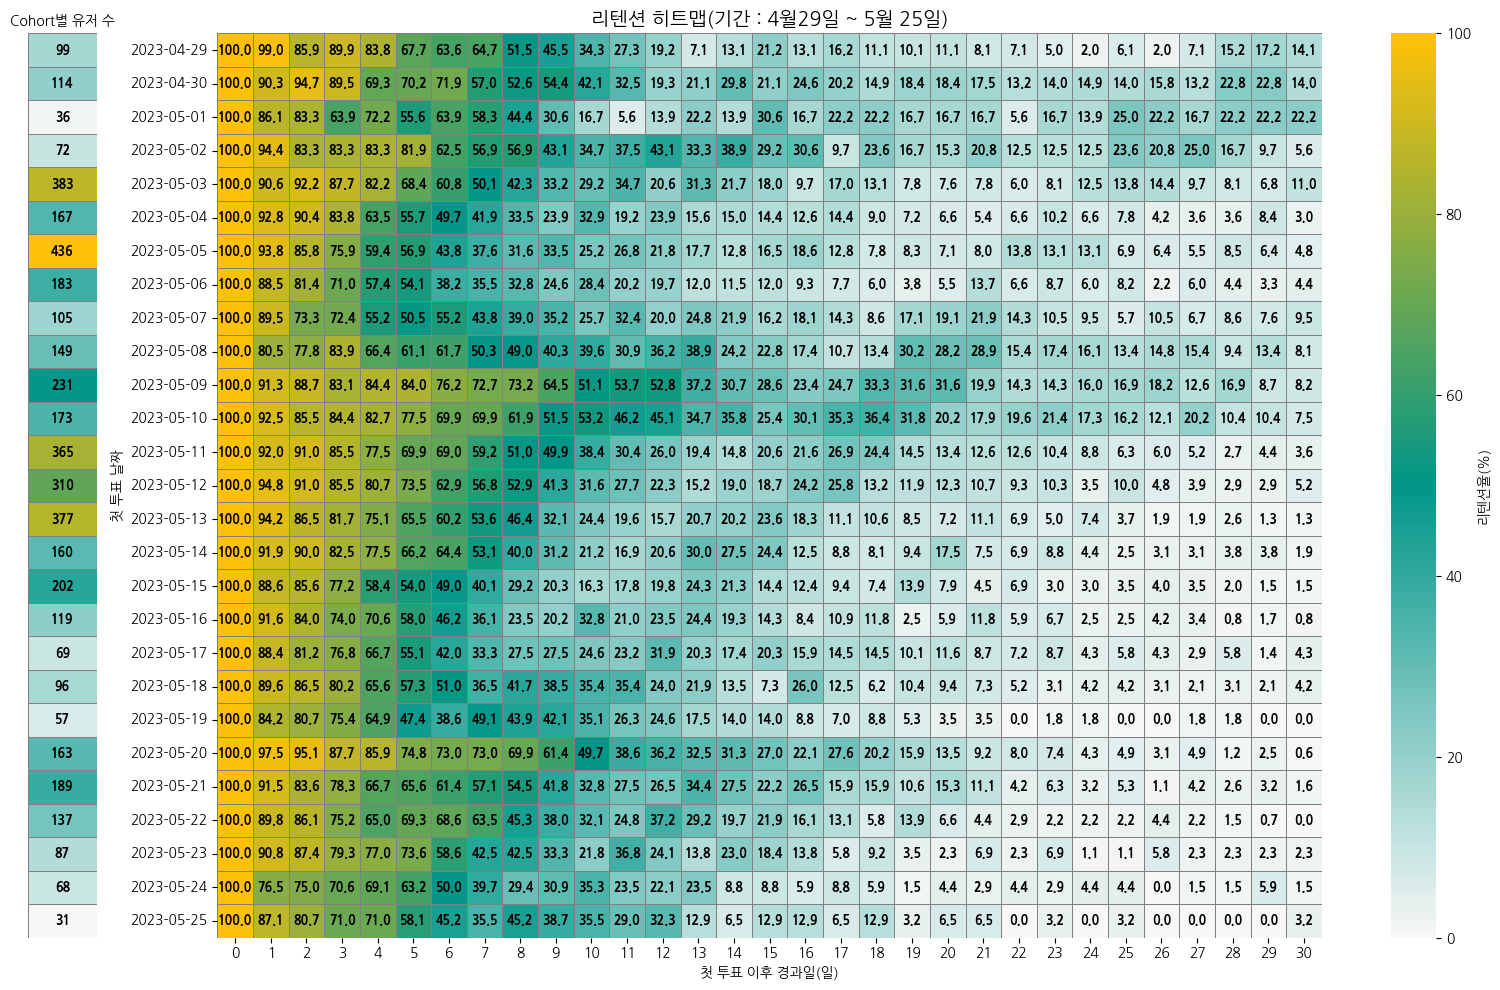

In [73]:
# 1. 인덱스 문자열 통일
retention.index = pd.to_datetime(retention.index)
retention.index = retention.index.strftime('%Y-%m-%d')

# 2. 데이터 분리
cohort_sizes = pd.DataFrame(retention['cohort_size'])
cohort_sizes.columns = ['Cohort Size']
heatmap_data = retention.drop(columns='cohort_size')

# 3. 서브플롯 구성
fig, (ax0, ax1) = plt.subplots(
    ncols=2,
    figsize=(16, 10),
    gridspec_kw={'width_ratios': [0.3, 6]} 
)

# 4. Cohort Size 히트맵
sns.heatmap(
    cohort_sizes,
    ax=ax0,
    annot=True, fmt="d", cmap=custom_cmap,
    annot_kws={"weight": "bold","color": "black", "size": 9},
    linewidths=0.5, linecolor='gray',
    cbar=False,
    yticklabels=False,
    xticklabels=False
)
ax0.set_ylabel("")
ax0.set_xlabel("")
ax0.set_title("Cohort별 유저 수", fontsize=10)

# 5. Retention 히트맵
sns.heatmap(
    heatmap_data,
    ax=ax1,
    annot=True, fmt=".1f", cmap=custom_cmap,
    annot_kws={"weight": "bold", "color": "black", "size": 9},
    linewidths=0.5, linecolor='gray',
    cbar_kws={'label': '리텐션율(%)'}
)
ax1.set_title("리텐션 히트맵(기간 : 4월29일 ~ 5월 25일)", fontsize=14)
ax1.set_xlabel("첫 투표 이후 경과일(일)")
ax1.set_ylabel("첫 투표 날짜")
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# 전체 정렬
plt.tight_layout()
plt.show()

#### 각 n-day별 평균 리텐션|

In [74]:
# cohort_size 제외한 day_n 컬럼만 선택
day_cols = [col for col in retention.columns if isinstance(col, int)]

# 각 day_n별 평균 리텐션율 계산
average_retention = retention[day_cols].mean()
average_retention

0     100.000000
1      90.299630
2      85.434815
3      79.621481
4      71.538148
5      64.257037
6      57.699259
7      50.670370
8      44.879259
9      38.048148
10     32.604815
11     28.357037
12     26.750370
13     23.548889
14     20.487778
15     19.431852
16     17.383333
17     15.170741
18     13.867037
19     12.399259
20     12.017407
21     11.304074
22      8.063704
23      8.840741
24      7.244815
25      8.046296
26      7.012222
27      6.824815
28      6.714074
29      6.314074
30      5.348148
dtype: float64

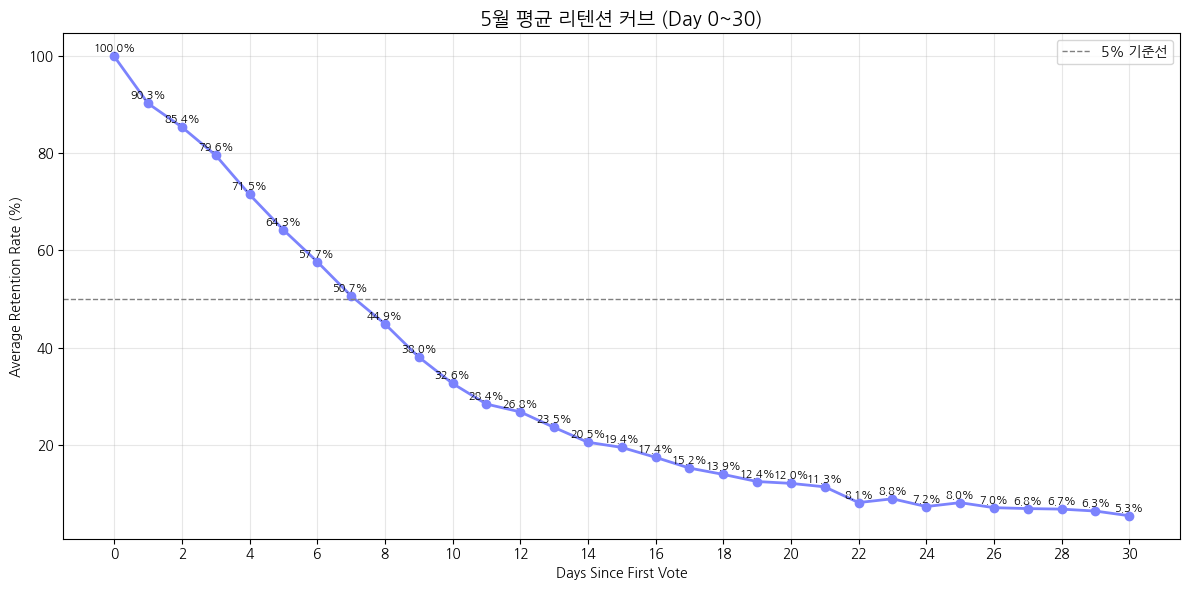

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(average_retention.index, average_retention.values, marker='o', color='#7C83FD', linewidth=2)

# 마커 위에 값 표시
for x, y in zip(average_retention.index, average_retention.values):
    plt.text(x, y + 1, f'{y:.1f}%', ha='center', fontsize=8)  

# 기준선
plt.axhline(y=50, color='gray', linestyle='--', linewidth=1, label='5% 기준선')

plt.title('5월 평균 리텐션 커브 (Day 0~30)', fontsize=14)
plt.xlabel('Days Since First Vote')
plt.ylabel('Average Retention Rate (%)')
plt.xticks(range(0, 31, 2))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#### 리텐션 유저 추출

In [76]:
# 1. first_vote_date 타입 datetime 변환
vote_df['first_vote_date'] = pd.to_datetime(vote_df['first_vote_date'])

# 2. 대상 기간 설정
start_date = pd.to_datetime('2023-04-29')
end_date = pd.to_datetime('2023-05-25')

# 3. 해당 기간에 첫 투표한 유저들의 활동 데이터 추출
cohort_user = vote_df[
    (vote_df['first_vote_date'] >= start_date) &
    (vote_df['first_vote_date'] <= end_date)
].copy()

# 4. 날짜별 유니크 유저 수 확인 (optional)
unique_counts = (
    cohort_user.groupby('first_vote_date')['user_id']
    .nunique()
    .reset_index(name='unique_user_count')
)

# 유니크 유저 수 출력
for _, row in unique_counts.iterrows():
    print(f"{row['first_vote_date'].date()} 유니크 유저 수: {row['unique_user_count']}")

2023-04-29 유니크 유저 수: 99
2023-04-30 유니크 유저 수: 114
2023-05-01 유니크 유저 수: 36
2023-05-02 유니크 유저 수: 72
2023-05-03 유니크 유저 수: 383
2023-05-04 유니크 유저 수: 167
2023-05-05 유니크 유저 수: 436
2023-05-06 유니크 유저 수: 183
2023-05-07 유니크 유저 수: 105
2023-05-08 유니크 유저 수: 149
2023-05-09 유니크 유저 수: 231
2023-05-10 유니크 유저 수: 173
2023-05-11 유니크 유저 수: 365
2023-05-12 유니크 유저 수: 310
2023-05-13 유니크 유저 수: 377
2023-05-14 유니크 유저 수: 160
2023-05-15 유니크 유저 수: 202
2023-05-16 유니크 유저 수: 119
2023-05-17 유니크 유저 수: 69
2023-05-18 유니크 유저 수: 96
2023-05-19 유니크 유저 수: 57
2023-05-20 유니크 유저 수: 163
2023-05-21 유니크 유저 수: 189
2023-05-22 유니크 유저 수: 137
2023-05-23 유니크 유저 수: 87
2023-05-24 유니크 유저 수: 68
2023-05-25 유니크 유저 수: 31


In [77]:
# 4월 29일 첫 투표 유저 ~ 5월 25일 첫 투표 유저 추출
cohort_user = cohort_user[['user_id', 'first_vote_date']]
cohort_user = cohort_user.drop_duplicates(subset = 'user_id').reset_index(drop = True)
cohort_user

,user_id,first_vote_date
0,838023,2023-04-29
1,838466,2023-05-02
2,839357,2023-04-29
3,840293,2023-05-03
4,840473,2023-05-03
...,...,...
4573,1510561,2023-05-25
4574,1511957,2023-05-25
4575,1512422,2023-05-25
4576,1512542,2023-05-25


In [78]:
# 1. 분위수 계산
q25 = retention[8].quantile(0.25)
q75 = retention[8].quantile(0.75)

# 2. 하위 25%에 해당하는 코호트 날짜
bottom_25_dates = retention[retention[8] <= q25].reset_index()

# 3. 상위 25%에 해당하는 코호트 날짜
top_25_dates = retention[retention[8] >= q75].reset_index()

# 4. 출력 (선택)
print("8일차 리텐션 하위 25% 코호트 날짜:")
display(bottom_25_dates)

print("8일차 리텐션 상위 25% 코호트 날짜:")
display(top_25_dates)


8일차 리텐션 하위 25% 코호트 날짜:


,first_vote_date,cohort_size,0,1,2,3,4,5,6,7,...,21,22,23,24,25,26,27,28,29,30
0,2023-05-04,167,100.0,92.81,90.42,83.83,63.47,55.69,49.70,41.92,...,5.39,6.59,10.18,6.59,7.78,4.19,3.59,3.59,8.38,2.99
1,2023-05-05,436,100.0,93.81,85.78,75.92,59.40,56.88,43.81,37.61,...,8.03,13.76,13.07,13.07,6.88,6.42,5.50,8.49,6.42,4.82
2,2023-05-06,183,100.0,88.52,81.42,71.04,57.38,54.10,38.25,35.52,...,13.66,6.56,8.74,6.01,8.20,2.19,6.01,4.37,3.28,4.37
3,2023-05-15,202,100.0,88.61,85.64,77.23,58.42,53.96,49.01,40.10,...,4.46,6.93,2.97,2.97,3.47,3.96,3.47,1.98,1.49,1.49
4,2023-05-16,119,100.0,91.60,84.03,73.95,70.59,57.98,46.22,36.13,...,11.76,5.88,6.72,2.52,2.52,4.20,3.36,0.84,1.68,0.84
5,2023-05-17,69,100.0,88.41,81.16,76.81,66.67,55.07,42.03,33.33,...,8.70,7.25,8.70,4.35,5.80,4.35,2.90,5.80,1.45,4.35
6,2023-05-24,68,100.0,76.47,75.00,70.59,69.12,63.24,50.00,39.71,...,2.94,4.41,2.94,4.41,4.41,0.00,1.47,1.47,5.88,1.47


8일차 리텐션 상위 25% 코호트 날짜:


,first_vote_date,cohort_size,0,1,2,3,4,5,6,7,...,21,22,23,24,25,26,27,28,29,30
0,2023-04-30,114,100.0,90.35,94.74,89.47,69.30,70.18,71.93,57.02,...,17.54,13.16,14.04,14.91,14.04,15.79,13.16,22.81,22.81,14.04
1,2023-05-02,72,100.0,94.44,83.33,83.33,83.33,81.94,62.50,56.94,...,20.83,12.50,12.50,12.50,23.61,20.83,25.00,16.67,9.72,5.56
2,2023-05-09,231,100.0,91.34,88.74,83.12,84.42,83.98,76.19,72.73,...,19.91,14.29,14.29,16.02,16.88,18.18,12.55,16.88,8.66,8.23
3,2023-05-10,173,100.0,92.49,85.55,84.39,82.66,77.46,69.94,69.94,...,17.92,19.65,21.39,17.34,16.18,12.14,20.23,10.40,10.40,7.51
4,2023-05-12,310,100.0,94.84,90.97,85.48,80.65,73.55,62.90,56.77,...,10.65,9.35,10.32,3.55,10.00,4.84,3.87,2.90,2.90,5.16
5,2023-05-20,163,100.0,97.55,95.09,87.73,85.89,74.85,73.01,73.01,...,9.20,7.98,7.36,4.29,4.91,3.07,4.91,1.23,2.45,0.61
6,2023-05-21,189,100.0,91.53,83.60,78.31,66.67,65.61,61.38,57.14,...,11.11,4.23,6.35,3.17,5.29,1.06,4.23,2.65,3.17,1.59


In [79]:
# 각 그룹의 cohort_size 합 -> 25% 이상 한명이 부족함 1253명임
under_25_total = bottom_25_dates['cohort_size'].sum()
over_25_total = top_25_dates['cohort_size'].sum()

print(f"8일차 리텐션이 25% 이하인 그룹의 전체 cohort_size 합: {under_25_total}")
print(f"8일차 리텐션이 25% 이상인 그룹의 전체 cohort_size 합: {over_25_total}")

8일차 리텐션이 25% 이하인 그룹의 전체 cohort_size 합: 1244
8일차 리텐션이 25% 이상인 그룹의 전체 cohort_size 합: 1252


## 5. 7일차 기준 날짜 코호트 집단 비교
    - 리텐션 높은 집단 : 5월 20일(73%)
    - 리텐션 낮은 집돈 : 5월 17일(33.3%)
    - 플로우(인과관계X)
        - 리텐션이 높은 집단은 어떤 행동 비율이 높았다. -> 향후 리텐션 향상을 위한 유의미한 인사이트로 해석 될 수 있다.
            - A 행동을 유도하면 리텐션이 높아진다” 식의 정책 제안이나 마케팅 전략 도출은 ‘가설’ 수준으로 언급
            - 이후 실험 또는 장기 데이터 관찰로 재검증(A/B TEST 설계)

### 5-1. 해당 집단 유저 추출

In [44]:
# 1. first_vote_date 타입 datetime 변환
vote_df['first_vote_date'] = pd.to_datetime(vote_df['first_vote_date'])

# 2. 두 날짜에 해당하는 유저들의 전체 활동 데이터 추출
target_dates = [pd.to_datetime('2023-05-17'), pd.to_datetime('2023-05-20')]
cohort_may_df = vote_df[vote_df['first_vote_date'].isin(target_dates)].copy()

# 3. 유니크 유저 수 확인 (날짜별)
for date in target_dates:
    user_count = cohort_may_df[cohort_may_df['first_vote_date'] == date]['user_id'].nunique()
    print(f"{date.date()} 유니크 유저 수: {user_count}")

# 4. 'label' 컬럼 생성: 5월 20일 → 'h', 5월 17일 → 'l'
cohort_may_df['label'] = cohort_may_df['first_vote_date'].apply(
    lambda x: 'h' if x == pd.to_datetime('2023-05-20') else 'l'
)

# 5. 불필요한 컬럼 제거
cohort_may_df.drop(columns=['vote_sequence'], inplace=True)

cohort_may_df

2023-05-17 유니크 유저 수: 69
2023-05-20 유니크 유저 수: 163


,user_id,vote_date,daily_vote_count,first_vote_date,day_n,label
2474,855230,2023-05-20,28,2023-05-20,0,h
2475,855230,2023-05-21,120,2023-05-20,1,h
2476,855230,2023-05-22,44,2023-05-20,2,h
2477,855230,2023-05-23,22,2023-05-20,3,h
2478,855230,2023-05-24,34,2023-05-20,4,h
...,...,...,...,...,...,...
44854,1414233,2023-05-26,20,2023-05-20,6,h
44855,1414233,2023-05-27,29,2023-05-20,7,h
44856,1414233,2023-05-28,8,2023-05-20,8,h
44857,1414233,2023-05-30,18,2023-05-20,10,h


In [45]:
# 유저와 label만 추출
cohort_users = cohort_may_df[['user_id', 'first_vote_date', 'label']].drop_duplicates()
cohort_users

,user_id,first_vote_date,label
2474,855230,2023-05-20,h
10461,878156,2023-05-20,h
11671,881242,2023-05-20,h
12141,882900,2023-05-20,h
12203,883165,2023-05-20,h
...,...,...,...
44779,1412867,2023-05-20,h
44795,1413257,2023-05-20,h
44811,1413294,2023-05-20,h
44827,1413576,2023-05-20,h


### 5-2. 행동 변수 분석

#### 1. 출석체크 여부 비교
    - 출석 체크 안한 코호트 유저들 존재한다... -> 분석 탈락

In [46]:
blob = bucket.blob('votes/accounts_attendance.parquet')
parquet_bytes = blob.download_as_bytes()
attendance = pd.read_parquet(io.BytesIO(parquet_bytes))
attendance.head()

,id,attendance_date_list,user_id
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453


In [47]:
# 1. 병합 (cohort 유저 중 출석 정보가 있는 유저만)
cohort_attendance = pd.merge(
    cohort_users, attendance[['user_id', 'attendance_date_list']],
    on='user_id', how='inner'
)

display(cohort_attendance)
print(f"출석 정보가 있는 코호트 유저 수: {cohort_attendance['user_id'].nunique()}")

,user_id,first_vote_date,label,attendance_date_list
0,882900,2023-05-20,h,"[""2023-05-29"", ""2023-05-30"", ""2023-05-31"", ""20..."
1,883165,2023-05-20,h,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20..."
2,899988,2023-05-17,l,"[""2023-05-30"", ""2023-06-01""]"
3,1064172,2023-05-20,h,"[""2023-05-29"", ""2023-05-31"", ""2023-06-01"", ""20..."
4,1084952,2023-05-17,l,"[""2023-05-28"", ""2023-05-29"", ""2023-05-30"", ""20..."
...,...,...,...,...
149,1412867,2023-05-20,h,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20..."
150,1413257,2023-05-20,h,"[""2023-05-28"", ""2023-05-29"", ""2023-05-31"", ""20..."
151,1413294,2023-05-20,h,"[""2023-05-30"", ""2023-05-31"", ""2023-06-01"", ""20..."
152,1413576,2023-05-20,h,"[""2023-05-27""]"


출석 정보가 있는 코호트 유저 수: 154


In [48]:
cohort_attendance['label'].value_counts()

label
h    120
l     34
Name: count, dtype: int64

In [49]:
# 출석 체크 페이지까지는 들어가서 있는 건지는 모르겠지만 이들은 제거
cohort_attendance[cohort_attendance['attendance_date_list'] == '[]']

,user_id,first_vote_date,label,attendance_date_list
47,1343653,2023-05-17,l,[]
65,1354545,2023-05-17,l,[]
133,1408631,2023-05-20,h,[]


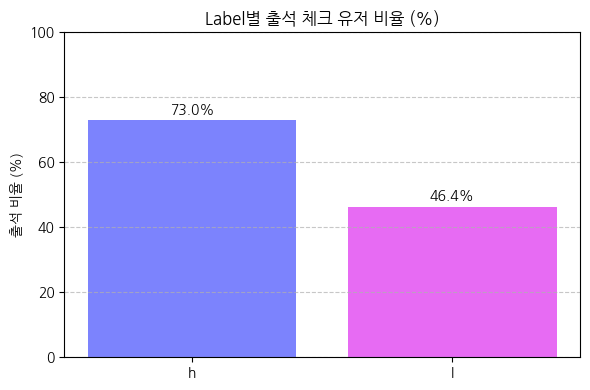

In [50]:
# 2. attendance_date_list 문자열을 리스트로 변환
cohort_attendance['attendance_date_list'] = cohort_attendance['attendance_date_list'].apply(ast.literal_eval)

# 3. 출석 날짜가 하나도 없는 유저 제거
cohort_attendance = cohort_attendance[cohort_attendance['attendance_date_list'].apply(lambda x: len(x) > 0)].copy()

# 4. 출석한 유저 리스트 추출
attended_users = cohort_attendance['user_id'].unique()

# 5. 전체 cohort_users에 출석 여부 컬럼 추가
cohort_users['attended'] = cohort_users['user_id'].isin(attended_users)

# 6. label별 출석률 계산
attendance_rate = (
    cohort_users.groupby('label')['attended']
    .mean()
    .reset_index(name='attendance_rate')
)

# 7. 시각화
plt.figure(figsize=(6, 4))
bars = plt.bar(attendance_rate['label'], attendance_rate['attendance_rate'] * 100, color=['#7C83FD', '#E76BF3'])
plt.title('Label별 출석 체크 유저 비율 (%)')
plt.ylabel('출석 비율 (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 바 위에 텍스트 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 2. 친구 요청 성공 여부
    - 2-1. 리텐션이 높은 집단은 친구 요청을 더 많이 보냈는가?
    - 2-2. 리테션이 높은 유저는 가입 초기에 친구 요청을 보냈는가?
    - 2-3. 친구 요청이 상호적인 경우(양방향 요청)은 리텐션에 영향을 주는가?
    - 2-4. 리텐션이 높은 집단은 수락된 친구 요청의 비율이 더 높은가?

In [51]:
blob = bucket.blob('votes/accounts_friendrequest.parquet')
parquet_bytes = blob.download_as_bytes()
friendrequest = pd.read_parquet(io.BytesIO(parquet_bytes))
friendrequest.head()

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521


In [52]:
# 1. 친구 요청 보낸 기록에서 send_user_id가 코호트 유저인 경우만 추출
cohort_friend_send = friendrequest[friendrequest['send_user_id'].isin(cohort_users['user_id'])].copy()

# 2. label 정보 붙이기 (코호트 유저 기준이므로 send_user_id 기준 merge)
cohort_friend_send = pd.merge(
    cohort_friend_send, 
    cohort_users[['user_id', 'label']], 
    left_on='send_user_id', 
    right_on='user_id', 
    how='left'
).drop(columns='user_id')

cohort_friend_send

,id,status,created_at,updated_at,receive_user_id,send_user_id,label
0,685757,P,2023-05-03 22:53:29,2023-05-03 22:53:29,866678,878156,h
1,685758,P,2023-05-03 22:53:29,2023-05-03 22:53:29,869490,878156,h
2,685759,A,2023-05-03 22:53:29,2023-05-05 04:35:34,869580,878156,h
3,685760,A,2023-05-03 22:53:29,2023-05-04 02:53:46,869718,878156,h
4,685761,A,2023-05-03 22:53:29,2023-05-04 00:16:04,871774,878156,h
...,...,...,...,...,...,...,...
5906,19276824,P,2023-06-08 09:19:58,2023-06-08 09:19:58,1356563,882900,h
5907,19276826,P,2023-06-08 09:20:09,2023-06-08 09:20:09,1446447,882900,h
5908,19373874,A,2023-06-11 11:37:18,2023-06-14 07:35:39,1402514,1257457,h
5909,19531398,P,2023-07-06 23:26:56,2023-07-06 23:26:56,1401832,1228869,h


In [53]:
# 전처리 고민
# send_user_id, receive_user_id가 같은데 status 상태가 다르다면 최종적인 status 상태로 남기는 것이 맞는건지
# updated_at 기준 친구 요청 최종 상태를 남기기로 함

# 1. 중복 확인

# 중복된 (send_user_id, receive_user_id) 조합 추출
cohort_friend_send_duplicated = cohort_friend_send[
    cohort_friend_send.duplicated(subset=['send_user_id', 'receive_user_id'], keep=False)
]

cohort_friend_send_duplicated=cohort_friend_send_duplicated.sort_values(by=['send_user_id', 'receive_user_id', 'updated_at'])
cohort_friend_send_duplicated

# updated_at 기준 정렬
cohort_friend_send =cohort_friend_send.sort_values(by=['send_user_id', 'receive_user_id', 'updated_at'])

# 2. updated_at 기준 최신 친구 요청 상태 최신 날짜로 남기기
cohort_friend_send = cohort_friend_send.drop_duplicates(subset=['send_user_id', 'receive_user_id'], keep='last')

# 결과 확인
display(cohort_friend_send)

,id,status,created_at,updated_at,receive_user_id,send_user_id,label
4880,13798309,P,2023-05-21 11:05:16,2023-05-21 11:05:16,892069,855230,h
4879,13798303,A,2023-05-21 11:05:16,2023-05-21 12:35:43,1256046,855230,h
2848,13190527,A,2023-05-20 12:12:26,2023-05-20 12:45:36,1402918,855230,h
4878,13798232,A,2023-05-21 11:05:12,2023-05-21 13:42:25,1406184,855230,h
4753,13700125,A,2023-05-21 08:24:10,2023-05-23 15:38:15,1418146,855230,h
...,...,...,...,...,...,...,...
5054,14046281,P,2023-05-21 15:07:22,2023-05-21 15:07:22,1411118,1414233,h
4474,13515308,A,2023-05-21 01:43:31,2023-05-21 02:15:07,1411402,1414233,h
4404,13484347,P,2023-05-20 23:50:27,2023-05-20 23:50:27,1412109,1414233,h
4471,13514965,A,2023-05-21 01:42:35,2023-05-21 04:00:07,1412867,1414233,h


In [54]:
# 유저별 친구 요청 횟수 집계
send_count = (
    cohort_friend_send.groupby('send_user_id')
    .size()
    .reset_index(name='send_count')
)

# label 붙이기
send_count = pd.merge(
    send_count, cohort_users[['user_id', 'label']],
    left_on='send_user_id', right_on='user_id', how='left'
).drop(columns='user_id')
display(send_count)

# label별 평균 친구 요청 횟수
send_avg_by_label = send_count.groupby('label')['send_count'].mean().reset_index()
send_avg_by_label

,send_user_id,send_count,label
0,855230,7,h
1,878156,10,h
2,882900,25,h
3,883165,10,h
4,883391,7,h
...,...,...,...
225,1412867,55,h
226,1413257,34,h
227,1413294,14,h
228,1413576,19,h


,label,send_count
0,h,23.496894
1,l,30.391304


,label,status,count,ratio
0,h,A,3106,82.104150
1,h,P,629,16.627016
2,h,R,48,1.268834
3,l,A,1710,81.545064
4,l,P,364,17.358131
5,l,R,23,1.096805


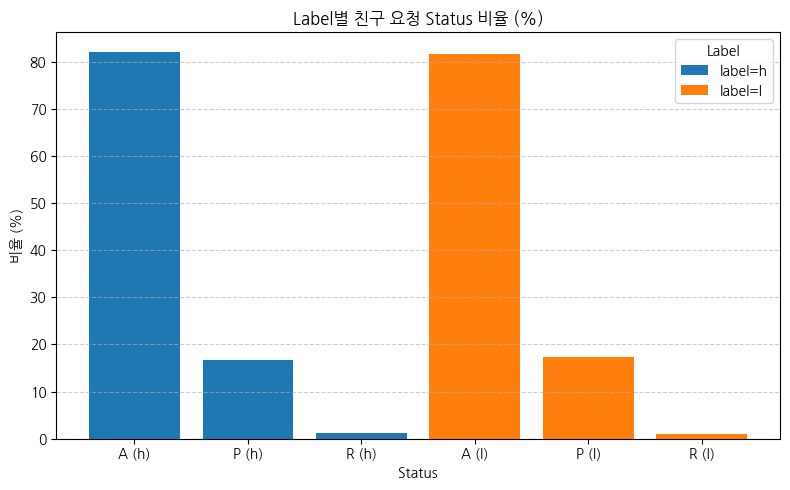

In [55]:
# 1. 상태별 요청 수 집계
status_count = cohort_friend_send.groupby(['label', 'status']).size().reset_index(name='count')

# 2. label별 전체 수로 나눠 비율 계산
total_per_label = status_count.groupby('label')['count'].transform('sum')
status_count['ratio'] = (status_count['count'] / total_per_label) * 100

display(status_count)

# 3. 시각화
plt.figure(figsize=(8, 5))
for label in status_count['label'].unique():
    subset = status_count[status_count['label'] == label]
    plt.bar(subset['status'] + f' ({label})', subset['ratio'], label=f'label={label}')

plt.title('Label별 친구 요청 Status 비율 (%)')
plt.ylabel('비율 (%)')
plt.xlabel('Status')
plt.legend(title='Label')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [56]:
from scipy.stats import chi2_contingency

contingency = pd.pivot_table(
    data=status_count,
    index='label', columns='status',
    values='count',
    aggfunc='sum',
    fill_value=0
)

display(contingency)

# 카이제곱 검정

chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-squared 통계량: {chi2:.4f}")
print(f"p-value: {p:.4f}")
print(f"자유도: {dof}")

# Cramér's 
n = contingency.to_numpy().sum()  # 전체 표본 수
min_dim = min(contingency.shape) - 1  # Cramér's V 계산에 사용할 자유도

# Cramér's V 계산
cramers_v = np.sqrt(chi2 / (n * min_dim))
print(f"Cramér's V: {cramers_v:.4f}")

status,A,P,R
label,,,
h,3106,629,48
l,1710,364,23


Chi-squared 통계량: 0.8092
p-value: 0.6673
자유도: 2
Cramér's V: 0.0117


#### 친구 요청 상태 "A"인 유저 라벨별 평균 친구 수락 수

In [57]:
# 1. 전체 요청 수 집계 (label별)
total_by_label = cohort_friend_send.groupby('label').size().reset_index(name='total')

# 2. 수락된 요청(A 상태) 수 집계 (label별)
accepted_by_label = cohort_friend_send[cohort_friend_send['status'] == 'A'].groupby('label').size().reset_index(name='accepted')

# 3. 병합 후 비율 계산
acceptance_rate = pd.merge(accepted_by_label, total_by_label, on='label')
acceptance_rate['accepted_ratio'] = (acceptance_rate['accepted'] / acceptance_rate['total']) * 100
acceptance_rate

,label,accepted,total,accepted_ratio
0,h,3106,3783,82.104150
1,l,1710,2097,81.545064


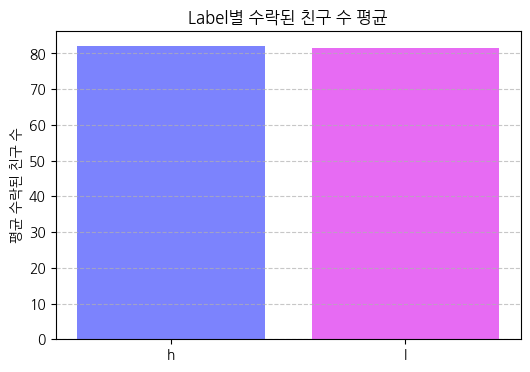

In [58]:
plt.figure(figsize=(6, 4))
plt.bar(acceptance_rate['label'], acceptance_rate['accepted_ratio'], color=['#7C83FD', '#E76BF3'])
plt.title('Label별 수락된 친구 수 평균')
plt.ylabel('평균 수락된 친구 수')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 두 코호트 집단 친구 요청 수락 비율 z-검정
    - 귀무가설 (H₀)	두 집단의 수락 비율에 차이가 없다
    - 대립가설 (H₁)	두 집단의 수락 비율에 차이가 있다
- 결과 해석
    - 리텐션이 높은 집단(H)과 낮은 집단(L) 간의 친구 요청 수락 비율에 통계적으로 유의미한 차이가 없다
    - 0.2 미만 → 무시해도 될 정도의 매우 작은 효과
    - 친구 요청 수락 비율은 리텐션 수준(H vs L)에 따른 의미 있는 차이 변수로 보기 어렵다.    
        → 리텐션과 연관성이 뚜렷하지 않음

In [59]:
# H, L 그룹 선택
H = acceptance_rate.loc[acceptance_rate['label'] == 'h']
L = acceptance_rate.loc[acceptance_rate['label'] == 'l']

# 값 추출
successes = [int(H['accepted'].iloc[0]), int(L['accepted'].iloc[0])]
totals = [int(H['total'].iloc[0]), int(L['total'].iloc[0])]

# 비율 차이 검정(Z-검정)
# H와 L 그룹의 수락 비율이 통계적으로 유의한가?
from statsmodels.stats.proportion import proportions_ztest

z_stat, p_val = proportions_ztest(count=successes, nobs=totals)

print(f"Z-statistic: {z_stat:.4f}")
print(f"p-value: {p_val:.4f}")


Z-statistic: 0.5334
p-value: 0.5937


In [60]:
# 비율 차이 효과 크기 : Cohen's h
# 비율 값
p1 = successes[0] / totals[0]  # H 그룹 비율
p2 = successes[1] / totals[1]  # L 그룹 비율

# Cohen's h 계산
cohens_h = 2 * np.arcsin(np.sqrt(p1)) - 2 * np.arcsin(np.sqrt(p2))
print(f"Cohen's h: {cohens_h:.4f}")

Cohen's h: 0.0145


In [61]:
# 가입 후 며칠 내 친구 요청을 보냈는지

# created_at을 datetime으로 변환
cohort_friend_send['created_at'] = pd.to_datetime(cohort_friend_send['created_at'])
cohort_users['first_vote_date'] = pd.to_datetime(cohort_users['first_vote_date'])

# 유저의 first_vote_date를 친구 요청 데이터에 merge
cohort_friend_send = pd.merge(
    cohort_friend_send,
    cohort_users[['user_id', 'first_vote_date']],
    left_on='send_user_id',
    right_on='user_id',
    how='left'
)

# 가입 후 친구 요청까지 걸린 일수 계산 (day_n)
cohort_friend_send['request_day_n'] = (cohort_friend_send['created_at'] - cohort_friend_send['first_vote_date']).dt.days

# 필요 없는 중복 user_id 컬럼 제거
cohort_friend_send.drop(columns='user_id', inplace=True)

# 결과 확인
display(cohort_friend_send[['send_user_id', 'first_vote_date', 'created_at', 'request_day_n', 'label']])


,send_user_id,first_vote_date,created_at,request_day_n,label
0,855230,2023-05-20,2023-05-21 11:05:16,1,h
1,855230,2023-05-20,2023-05-21 11:05:16,1,h
2,855230,2023-05-20,2023-05-20 12:12:26,0,h
3,855230,2023-05-20,2023-05-21 11:05:12,1,h
4,855230,2023-05-20,2023-05-21 08:24:10,1,h
...,...,...,...,...,...
5875,1414233,2023-05-20,2023-05-21 15:07:22,1,h
5876,1414233,2023-05-20,2023-05-21 01:43:31,1,h
5877,1414233,2023-05-20,2023-05-20 23:50:27,0,h
5878,1414233,2023-05-20,2023-05-21 01:42:35,1,h


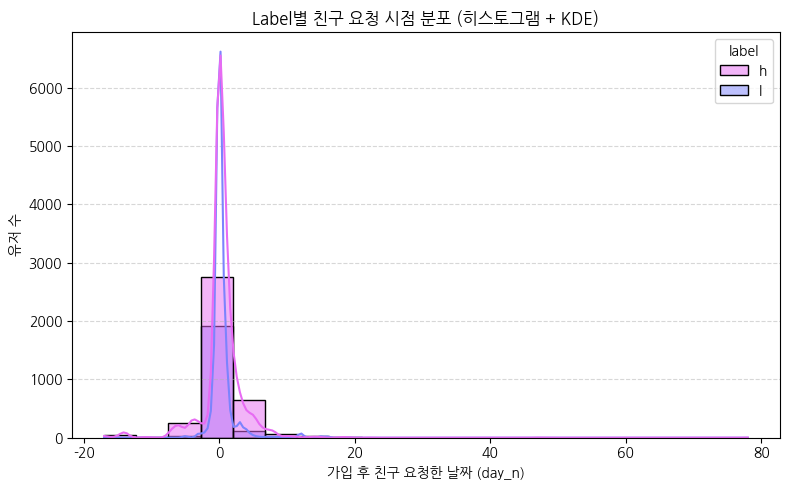

In [62]:
plt.figure(figsize=(8, 5))
sns.histplot(data=cohort_friend_send, x='request_day_n', hue='label', kde=True, bins=20, palette=['#E76BF3', '#7C83FD'])
plt.title('Label별 친구 요청 시점 분포 (히스토그램 + KDE)')
plt.xlabel('가입 후 친구 요청한 날짜 (day_n)')
plt.ylabel('유저 수')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 리텐션하다가 잘못된 길로 간 결과

In [63]:
# 재투표인 사람들 확인하기
repeat_vote = user_daily_vote_df[user_daily_vote_df['vote_sequence'] > 1]
display(repeat_vote)

# 재투표한 유저 수
print(f"재투표 진행 유니크 유저 수 : {repeat_vote['user_id'].nunique()}")

# 전체 투표 기록 유저수 
print(f"투표 진행 유니크 유저 수 : {questionrecord_df['user_id'].nunique()}")

# 5월 ~ 7월 투표 진행 유저 중 재투표 유저 비율
repeat_vote_rate = round(
    (repeat_vote['user_id'].nunique() / questionrecord_df['user_id'].nunique()) * 100,
    2)
print(f"5월 ~ 7월 투표 진행 유저 중 1번이라도 재투표 유저 비율 : {repeat_vote_rate}%")

,user_id,vote_date,daily_vote_count,vote_sequence
1,838023,2023-04-30,6,2
2,838023,2023-05-02,1,3
3,838023,2023-05-03,10,4
4,838023,2023-05-04,4,5
6,838466,2023-05-03,34,2
...,...,...,...,...
50238,1577440,2023-06-30,4,2
50241,1579418,2023-07-26,17,2
50242,1579418,2023-07-28,7,3
50243,1579418,2023-07-29,7,4


재투표 진행 유니크 유저 수 : 4695
투표 진행 유니크 유저 수 : 4845
5월 ~ 7월 투표 진행 유저 중 1번이라도 재투표 유저 비율 : 96.9%


In [64]:
# 필요 없음
repeat_vote = repeat_vote.copy()

repeat_vote['month'] = pd.to_datetime(repeat_vote['vote_date']).dt.to_period('M')

# 4. 월별 재투표 유저 수 집계
monthly_repeat_vote = (
    repeat_vote
    .groupby('month')['user_id']
    .nunique()
    .reset_index(name='repeat_voter_count')
)

# 월별 재투표 유저 수
monthly_repeat_vote

,month,repeat_voter_count
0,2023-04,220
1,2023-05,4645
2,2023-06,1863
3,2023-07,387


In [65]:
# 1. 재투표 유저 필터링
repeat_votes = user_daily_vote_df[user_daily_vote_df['vote_sequence'] >= 2]

# 2. 일자별 재투표 유저 수 집계
daily_repeat_count = (
    repeat_votes
    .groupby('vote_date')['user_id']
    .nunique()
    .reset_index(name='repeat_voter_count')
)

# 3. 전체 날짜 생성 (5월 1일 ~ 7월 31일)
all_dates = pd.date_range(start='2023-05-01', end='2023-07-31')
all_dates_df = pd.DataFrame({'vote_date': all_dates.date})

# 4. 전체 날짜 기준으로 merge → 없는 날짜는 0으로
daily_repeat_count = pd.merge(
    all_dates_df,
    daily_repeat_count,
    on='vote_date',
    how='left'
).fillna({'repeat_voter_count': 0})

# 5. 정수형 변환
daily_repeat_count['repeat_voter_count'] = daily_repeat_count['repeat_voter_count'].astype(int)
daily_repeat_count

,vote_date,repeat_voter_count
0,2023-05-01,289
1,2023-05-02,341
2,2023-05-03,373
3,2023-05-04,653
4,2023-05-05,812
...,...,...
87,2023-07-27,14
88,2023-07-28,14
89,2023-07-29,17
90,2023-07-30,11


In [66]:
# 'date' 컬럼과 'vote_date' 컬럼 이름 맞추기
ratio_df = ratio_df.rename(columns={'date': 'vote_date'})

# 병합
vote_with_repeat = pd.merge(
    daily_repeat_count,  
    ratio_df,  # 재투표 유저 수 포함 데이터
    on='vote_date',
    how='left'
)
# 컬럼명 설명
# vote_date : 투표 이루어진 날짜
# repeat_voter_count : 재투표한 유저 수
# daily_vote_count : 일별 투표 유저 수
# cumulative_user_count : 누적 회원가입 유저 수
# vote_rate : 일별 투표 유저 수 / 누적 회원가입 유저 수
vote_with_repeat.head()

,vote_date,repeat_voter_count,daily_vote_count,cumulative_user_count,vote_rate
0,2023-05-01,289,325,446,72.87
1,2023-05-02,341,413,545,75.78
2,2023-05-03,373,756,934,80.94
3,2023-05-04,653,820,1118,73.35
4,2023-05-05,812,1248,1552,80.41


In [67]:
# 재투표율 계산 : 해당일 재투표 유저 수 / 해당일 투표 유저 수
# 재투표율 계산 후 새로운 컬럼으로 추가
vote_with_repeat['repeat_vote_rate'] = (
    vote_with_repeat['repeat_voter_count'] / vote_with_repeat['daily_vote_count'] * 100
).round(2)  

In [68]:
# 5,6,7월 종합적 투표 계산 데이터 프레임
vote_with_repeat

,vote_date,repeat_voter_count,daily_vote_count,cumulative_user_count,vote_rate,repeat_vote_rate
0,2023-05-01,289,325,446,72.87,88.92
1,2023-05-02,341,413,545,75.78,82.57
2,2023-05-03,373,756,934,80.94,49.34
3,2023-05-04,653,820,1118,73.35,79.63
4,2023-05-05,812,1248,1552,80.41,65.06
...,...,...,...,...,...,...
87,2023-07-27,14,14,5074,0.28,100.00
88,2023-07-28,14,14,5074,0.28,100.00
89,2023-07-29,17,17,5074,0.34,100.00
90,2023-07-30,11,11,5074,0.22,100.00
